## Ungraded Lab: Convolutional Autoencoders

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/TensorFlow-Advanced_Techniques_Specialization/blob/master/Generative_Deep_Learning_with_TensorFlow/Week2/Labs/C4_W2_Lab_4_FashionMNIST_CNNAutoEncoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a>

In this lab, you will use convolution layers to build your autoencoder. This usually leads to better results than dense networks and you will see it in action with the [Fashion MNIST dataset](https://www.tensorflow.org/datasets/catalog/fashion_mnist).

## Imports

In [1]:
# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass

import tensorflow as tf
from keras import layers, Model, optimizers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

2024-09-12 15:36:53.908777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 15:36:53.921081: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 15:36:53.924557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 15:36:53.933327: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare the Dataset

As before, you will load the train and test sets from TFDS. Notice that we don't flatten the image this time. That's because we will be using convolutional layers later that can deal with 2D images.

In [2]:
def map_image(image, label):
    '''Normalizes the image. Returns image as input and label.'''
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0

    return image, image

In [3]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

2024-09-12 15:36:55.990030: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Could not resolve hostname', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

2024-09-12 15:37:13.244440: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1807 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Shuffling /home/luis-mendoza/tensorflow_datasets/fashion_mnist/3.0.1.incompleteI0EF8Z/fashion_mnist-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/luis-mendoza/tensorflow_datasets/fashion_mnist/3.0.1.incompleteI0EF8Z/fashion_mnist-test.tfrec…

Dataset fashion_mnist downloaded and prepared to /home/luis-mendoza/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


## Define the Model

As mentioned, you will use convolutional layers to build the model. This is composed of three main parts: encoder, bottleneck, and decoder. You will follow the configuration shown in the image below.

<img src="./images/AutoEncoder.png" width="75%" height="75%"/>

The encoder, just like in previous labs, will contract with each additional layer. The features are generated with the Conv2D layers while the max pooling layers reduce the dimensionality.

In [4]:
def encoder(inputs):
    '''Defines the encoder with two Conv2D and max pooling layers.'''
    conv_1 = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    max_pool_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv_1)

    conv_2 = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(max_pool_1)
    max_pool_2 = layers.MaxPooling2D(pool_size=(2, 2))(conv_2)

    return max_pool_2

A bottleneck layer is used to get more features but without further reducing the dimension afterwards. Another layer is inserted here for visualizing the encoder output.

In [5]:
def bottle_neck(inputs):
    '''Defines the bottleneck.'''
    bottle_neck = layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    encoder_visualization = layers.Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(bottle_neck)

    return bottle_neck, encoder_visualization

The decoder will upsample the bottleneck output back to the original image size.

In [6]:
def decoder(inputs):
    '''Defines the decoder path to upsample back to the original image size.'''
    conv_1 = layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    up_sample_1 = layers.UpSampling2D(size=(2, 2))(conv_1)

    conv_2 = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(up_sample_1)
    up_sample_2 = layers.UpSampling2D(size=(2, 2))(conv_2)

    conv_3 = layers.Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(up_sample_2)

    return conv_3

You can now build the full autoencoder using the functions above.

In [7]:
def convolutional_auto_encoder():
    '''Builds the entire autoencoder model.'''
    inputs = layers.Input(shape=(28, 28, 1,))
    encoder_output = encoder(inputs)
    bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
    decoder_output = decoder(bottleneck_output)

    model = Model(inputs =inputs, outputs=decoder_output)
    encoder_model = Model(inputs=inputs, outputs=encoder_visualization)
    
    return model, encoder_model

In [8]:
convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 1)      │           577 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739,073 (2.82 MB)

 Trainable params: 739,073 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train the model

In [9]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=40)

Epoch 1/40


I0000 00:00:1726177056.146955   75708 service.cc:146] XLA service 0x788620003070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726177056.146990   75708 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-09-12 15:37:36.191915: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-12 15:37:36.355996: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90201


  6/468 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.6563

I0000 00:00:1726177060.313828   75708 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 0.3301 - val_loss: 0.2656
Epoch 2/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - loss: 0.2620 - val_loss: 0.2592
Epoch 3/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2561 - val_loss: 0.2560
Epoch 4/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2531 - val_loss: 0.2547
Epoch 5/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2515 - val_loss: 0.2526
Epoch 6/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2500 - val_loss: 0.2519
Epoch 7/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2495 - val_loss: 0.2513
Epoch 8/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2487 - val_loss: 0.2507
Epoch 9/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2484 - val_loss: 0.2501
Epoch 10/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2480 - val_loss: 0.2500
Epoch 11/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.2478 - val_loss: 0.2494
Epoch 12/40
468/468 ━━━━━━━━━━━━━━━━━━━━ 

## Display sample results

As usual, let's see some sample results from the trained model.

In [10]:
def display_one_row(disp_images, offset, shape=(28, 28)):
    '''Display sample outputs in one row.'''
    for idx, test_image in enumerate(disp_images):
        plt.subplot(3, 10, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        test_image = np.reshape(test_image, shape)
        plt.imshow(test_image, cmap='gray')

def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8, 4)):
    '''Displays the input, encoded, and decoded output values.'''
    plt.figure(figsize=(15, 5))
    display_one_row(disp_input_images, 0, shape=(28, 28,))
    display_one_row(disp_encoded, 10, shape=enc_shape)
    display_one_row(disp_predicted, 20, shape=(28, 28,))

2024-09-12 15:46:33.453681: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


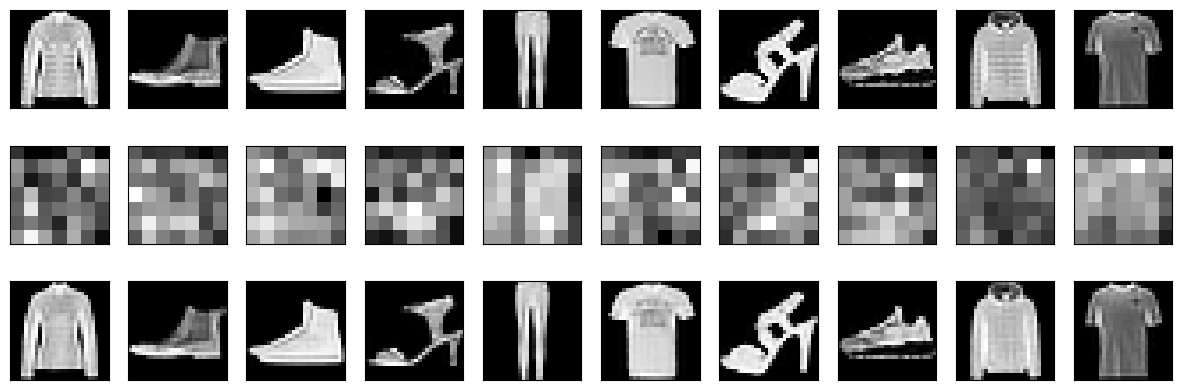

In [11]:
# Take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# Take the input images and put them in a list
output_samples = []

for input_image, image in tfds.as_numpy(test_dataset):
    output_samples = input_image

# Pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# Get the encoder ouput
encoded = convolutional_encoder_model.predict(conv_output_samples)

# Get a prediction for some values in the dataset
predicted = convolutional_model.predict(conv_output_samples)

# Display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(7, 7))